In [1]:
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import plotly.express as px
import plotly.io as pio
from plotly.offline import iplot
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, auc
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = all messages, 1 = filter INFO, 2 = filter WARNING, 3 = filter ERROR
import tensorflow as tf

pio.templates["plotly_dark"].layout.colorway = px.colors.qualitative.Set2
pio.templates.default = "plotly_dark" 

2025-04-27 17:15:37.089917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745774137.322790      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745774137.391379      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Directory structure
base_dir = "/kaggle/input/final-seg-dt/seg-dt"
image_size = (256, 256)

def load_image_and_mask(image_path, mask_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, image_size)
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, image_size)
    mask = np.expand_dims(mask, axis=-1)
    mask = np.where(mask > 0, 1, 0).astype(np.float32)
    
    return img, mask

def load_dataset(split):
    image_dir = os.path.join(base_dir, split, 'images')
    mask_dir = os.path.join(base_dir, split, 'masks')
    
    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
    mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
    
    images, masks = [], []
    for img_path, msk_path in zip(image_paths, mask_paths):
        img, msk = load_image_and_mask(img_path, msk_path)
        images.append(img)
        masks.append(msk)
        
    return np.array(images), np.array(masks)

# Load datasets
X_train, Y_train = load_dataset("train")
X_val, Y_val     = load_dataset("val")
X_test, Y_test   = load_dataset("test")

print(f"Train: {X_train.shape}, {Y_train.shape}")
print(f"Val:   {X_val.shape}, {Y_val.shape}")
print(f"Test:  {X_test.shape}, {Y_test.shape}")


Train: (3200, 256, 256, 3), (3200, 256, 256, 1)
Val:   (150, 256, 256, 3), (150, 256, 256, 1)
Test:  (50, 256, 256, 3), (50, 256, 256, 1)


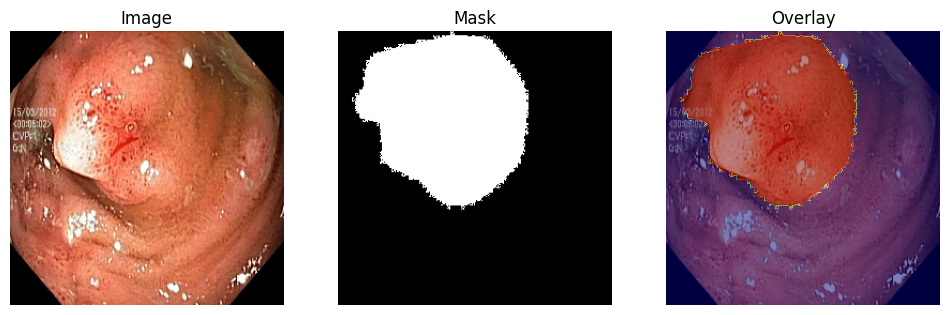

In [3]:
def show_sample(image, mask):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask[:, :, 0], cmap='gray')
    plt.title("Mask")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(mask[:, :, 0], cmap='jet', alpha=0.5)
    plt.title("Overlay")
    plt.axis('off')
    plt.show()

show_sample(X_train[0], Y_train[0])


In [4]:
# def u_net():
#     inputs = layers.Input(shape = (256,256,3))
#     inputs = layers.Rescaling(scale= 1./255)(inputs)
    
#     #Encoder
#     c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(inputs)
#     c1 = layers.BatchNormalization()(c1)
#     c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c1)
#     p1 = layers.MaxPooling2D((2, 2))(c1)

#     c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(p1)
#     c2 = layers.BatchNormalization()(c2)
#     c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c2)
#     p2 = layers.MaxPooling2D((2, 2))(c2)

#     c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(p2)
#     c3 = layers.BatchNormalization()(c3)
#     c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c3)
#     p3 = layers.MaxPooling2D((2, 2))(c3)

#     c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(p3)
#     c4 = layers.BatchNormalization()(c4)
#     c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c4)
#     p4 = layers.MaxPooling2D((2, 2))(c4)

#     c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(p4)
#     c5 = layers.BatchNormalization()(c5)
#     c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c5)
#     p5 = layers.MaxPooling2D((2, 2))(c5)
    
#     c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(p5)
#     c6 = layers.BatchNormalization()(c6)
#     c6 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c6)


#     # Decoder
#     u7 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = layers.concatenate([u7, c5])
#     c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(u7)
#     c7 = layers.BatchNormalization()(c7)
#     c7 = layers.Conv2D(512, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c7)

    
#     u8 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = layers.concatenate([u8, c4])
#     c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(u8)
#     c8 = layers.BatchNormalization()(c8)
#     c8 = layers.Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c8)


#     u9 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same',kernel_initializer = "he_normal")(c8)
#     u9 = layers.concatenate([u9, c3])
#     c9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(u9)
#     c9 = layers.BatchNormalization()(c9)
#     c9 = layers.Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c9)


#     u10 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same',kernel_initializer = "he_normal")(c9)
#     u10 = layers.concatenate([u10, c2])
#     c10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(u10)
#     c10 = layers.BatchNormalization()(c10)
#     c10 = layers.Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c10)

    
#     u11 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c10)
#     u11 = layers.concatenate([u11, c1])
#     c11 = layers.Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(u11)
#     c11 = layers.BatchNormalization()(c11)
#     c11 = layers.Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer = "he_normal")(c11)

    
#     outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)
    
#     model = models.Model(inputs=[inputs],outputs = [outputs])
#     model.compile(optimizer = 'adam', loss = "binary_crossentropy",metrics = ["accuracy",tf.metrics.BinaryIoU(target_class_ids=(0, 1))])
    
#     return model
#version 1

In [5]:
# import tensorflow as tf
# from tensorflow.keras import layers, models
# from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, GlobalMaxPooling2D,
#                                      BatchNormalization, Input, Conv2D, Concatenate,
#                                      Reshape, Multiply, Add, Activation, Lambda, Conv1D)

# # 🔸 Efficient Channel Attention (ECA) Block with Conv1D
# def eca_block(input_feature, k_size=3):
#     channel = input_feature.shape[-1]
#     avg_pool = GlobalAveragePooling2D()(input_feature)
#     avg_pool = Reshape((channel, 1))(avg_pool)
#     conv1d = Conv1D(1, kernel_size=k_size, padding='same', use_bias=False)(avg_pool)
#     attention = Activation('sigmoid')(conv1d)
#     attention = Reshape((1, 1, channel))(attention)
#     return Multiply()([input_feature, attention])

# # 🔹 Combined ECA + CBAM (Spatial only)
# def eca_cbam_block(input_feature):
#     # Channel-wise refinement
#     channel_refined = eca_block(input_feature)

#     # Spatial refinement
#     avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
#     max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
#     concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
#     spatial_attention = Conv2D(filters=1, kernel_size=7, padding='same', activation='sigmoid',
#                                kernel_initializer='he_normal', use_bias=False)(concat)
#     refined_feature = Multiply()([channel_refined, spatial_attention])
#     return refined_feature

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, GlobalMaxPooling2D,
                                     BatchNormalization, Input, Conv2D, Concatenate,
                                     Reshape, Multiply, Add, Activation, Lambda)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import EfficientNetB7

def cbam_block(input_feature, reduction_ratio=8):
    channel = input_feature.shape[-1]
    
    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)
    
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    max_pool = Reshape((1, 1, channel))(max_pool)
    
    shared_mlp = Sequential([
        Dense(channel // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=True),
        Dense(channel, kernel_initializer='he_normal', use_bias=True)
    ])
    
    mlp_avg = shared_mlp(avg_pool)
    mlp_max = shared_mlp(max_pool)
    
    channel_attention = Add()([mlp_avg, mlp_max])
    channel_attention = Activation('sigmoid')(channel_attention)
    channel_refined = Multiply()([input_feature, channel_attention])
    
    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    
    spatial_attention = Conv2D(filters=1, kernel_size=7, strides=1, padding='same',
                               activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(concat)
    refined_feature = Multiply()([channel_refined, spatial_attention])
    
    return refined_feature

# 🔧 U-Net Model with Attention
def attention_unet():
    inputs = layers.Input(shape=(256, 256, 3))
    x = layers.Rescaling(1. / 255)(inputs)

    # Encoder
    c1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c1)
    c1 = cbam_block(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c2)
    c2 = cbam_block(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c3)
    c3 = cbam_block(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c4)
    c4 = cbam_block(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c5)
    c5 = cbam_block(c5)

    # Decoder
    u6 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c6)
    c6 = cbam_block(c6)

    u7 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c7)
    c7 = cbam_block(c7)

    u8 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c8)
    c8 = cbam_block(c8)

    u9 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(c9)
    c9 = cbam_block(c9)

    outputs = Conv2D(1, 1, activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.BinaryIoU(target_class_ids=[0, 1])])
    return model

# Instantiate model
model = attention_unet()

# Model Summary
model.summary()


I0000 00:00:1745774227.127819      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745774227.128591      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 256, 256, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ rescaling[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 32)   │            128 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ conv2d_1[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 32)             │              0 │ conv2d_1[0][0]         │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 32)       │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 32)       │              0 │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential (Sequential)   │ (None, 1, 1, 32)       │            292 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 1, 1, 32)       │              0 │ sequential[0][0],      │
│                           │                        │                │ sequential[1][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 1, 32)       │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 256, 256, 32)   │              0 │ conv2d_1[0][0],        │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 256, 256, 1)    │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_1 (Lambda)         │ (None, 256, 256, 1)    │              0 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 256, 256, 2)    │              0 │ lambda[0][0],          │
│ (Concatenate)             │                        │                │ lambda_1[0][0]         │
├──────────────────────

 Total params: 7,872,729 (30.03 MB)

 Trainable params: 7,869,785 (30.02 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [6]:
# model = u_net()
# model.summary()
#version 1

In [7]:
# X_train, Y_train = load_dataset("train")
# X_val, Y_val     = load_dataset("val")
# X_test, Y_test

In [8]:
check_point = ModelCheckpoint('U-Net.keras', monitor='val_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.7,          
    patience=5,          
    min_lr=1e-7,        
    verbose=1       
)

history = model.fit(
    x=X_train,
    y=Y_train,
    epochs=50,
    validation_data=(X_val, Y_val),
    batch_size=16,
    callbacks=[check_point, reduce_lr]
)


Epoch 1/50


I0000 00:00:1745774256.331006      96 service.cc:148] XLA service 0x7a5000013e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745774256.331944      96 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745774256.331967      96 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745774258.664700      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-04-27 17:18:05.140127: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,256,256]{3,2,1,0}, f32[16,32,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_qu

200/200 ━━━━━━━━━━━━━━━━━━━━ 153s 443ms/step - accuracy: 0.7959 - binary_io_u: 0.3096 - loss: 0.4451 - val_accuracy: 0.8405 - val_binary_io_u: 0.4203 - val_loss: 0.4112 - learning_rate: 0.0010
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 349ms/step - accuracy: 0.8451 - binary_io_u: 0.3564 - loss: 0.3499 - val_accuracy: 0.8446 - val_binary_io_u: 0.4387 - val_loss: 0.4067 - learning_rate: 0.0010
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 348ms/step - accuracy: 0.8566 - binary_io_u: 0.4325 - loss: 0.3278 - val_accuracy: 0.8539 - val_binary_io_u: 0.5466 - val_loss: 0.3460 - learning_rate: 0.0010
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 70s 348ms/step - accuracy: 0.8578 - binary_io_u: 0.4284 - loss: 0.3278 - val_accuracy: 0.8543 - val_binary_io_u: 0.6148 - val_loss: 0.3306 - learning_rate: 0.0010
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 69s 343ms/step - accuracy: 0.8643 - binary_io_u: 0.4500 - loss: 0.3105 - val_accuracy: 0.8477 - val_binary_io_u: 0.5711 - val_loss: 0.3390 - learning_rate: 0.

2025-04-27 18:16:05.594377: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=0} for conv (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-04-27 18:16:05.646972: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.052753352s
Trying algorithm eng12{k11=0} for conv (f32[32,64,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,128,128]{3,2,1,0}, f32[64,128,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForwa

5/5 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.9353 - binary_io_u: 0.7871 - loss: 0.1855 

📊 Validation Metrics:
Loss: 0.1881
Accuracy: 0.9347
IoU: 0.7904
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.9191 - binary_io_u: 0.7773 - loss: 0.2270

📊 Test Metrics:
Loss: 0.2241
Accuracy: 0.9215
IoU: 0.7787
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step

📄 Classification Report:
              precision    recall  f1-score   support

  Background       0.94      0.97      0.95   2634409
      Object       0.84      0.74      0.79    642391

    accuracy                           0.92   3276800
   macro avg       0.89      0.85      0.87   3276800
weighted avg       0.92      0.92      0.92   3276800



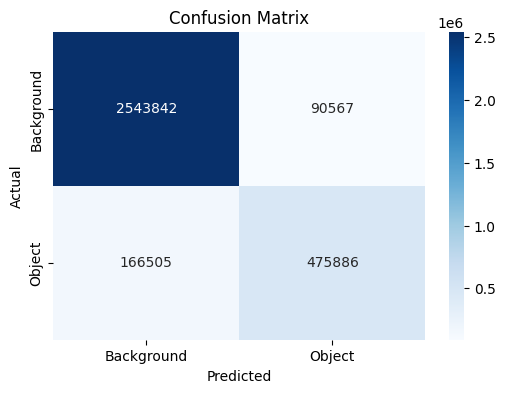


✅ Mean IoU on test set: 0.7093
✅ Mean Dice Score on test set: 0.8108


In [9]:
from sklearn.metrics import confusion_matrix, classification_report, jaccard_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Evaluate on Validation Set
val_loss, val_accuracy, val_iou = model.evaluate(X_val, Y_val, verbose=1)
print(f"\n📊 Validation Metrics:\nLoss: {val_loss:.4f}\nAccuracy: {val_accuracy:.4f}\nIoU: {val_iou:.4f}")

# 2. Evaluate on Test Set
test_loss, test_accuracy, test_iou = model.evaluate(X_test, Y_test, verbose=1)
print(f"\n📊 Test Metrics:\nLoss: {test_loss:.4f}\nAccuracy: {test_accuracy:.4f}\nIoU: {test_iou:.4f}")

# 3. Predict on Test Set
y_pred = model.predict(X_test)
y_pred_thresholded = (y_pred > 0.5).astype(np.uint8)

# 4. Flatten masks for classification report
y_test_flat = Y_test.flatten()
y_pred_flat = y_pred_thresholded.flatten()

# 5. Classification Report
print("\n📄 Classification Report:")
print(classification_report(y_test_flat, y_pred_flat, target_names=["Background", "Object"]))

# 6. Confusion Matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Object"], yticklabels=["Background", "Object"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 7. Mean IoU and Dice Score across test images
ious = []
dice_scores = []

for i in range(len(X_test)):
    true_mask = Y_test[i].flatten()
    pred_mask = y_pred_thresholded[i].flatten()
    
    iou = jaccard_score(true_mask, pred_mask, average='binary')
    dice = f1_score(true_mask, pred_mask, average='binary')
    
    ious.append(iou)
    dice_scores.append(dice)

print(f"\n✅ Mean IoU on test set: {np.mean(ious):.4f}")
print(f"✅ Mean Dice Score on test set: {np.mean(dice_scores):.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


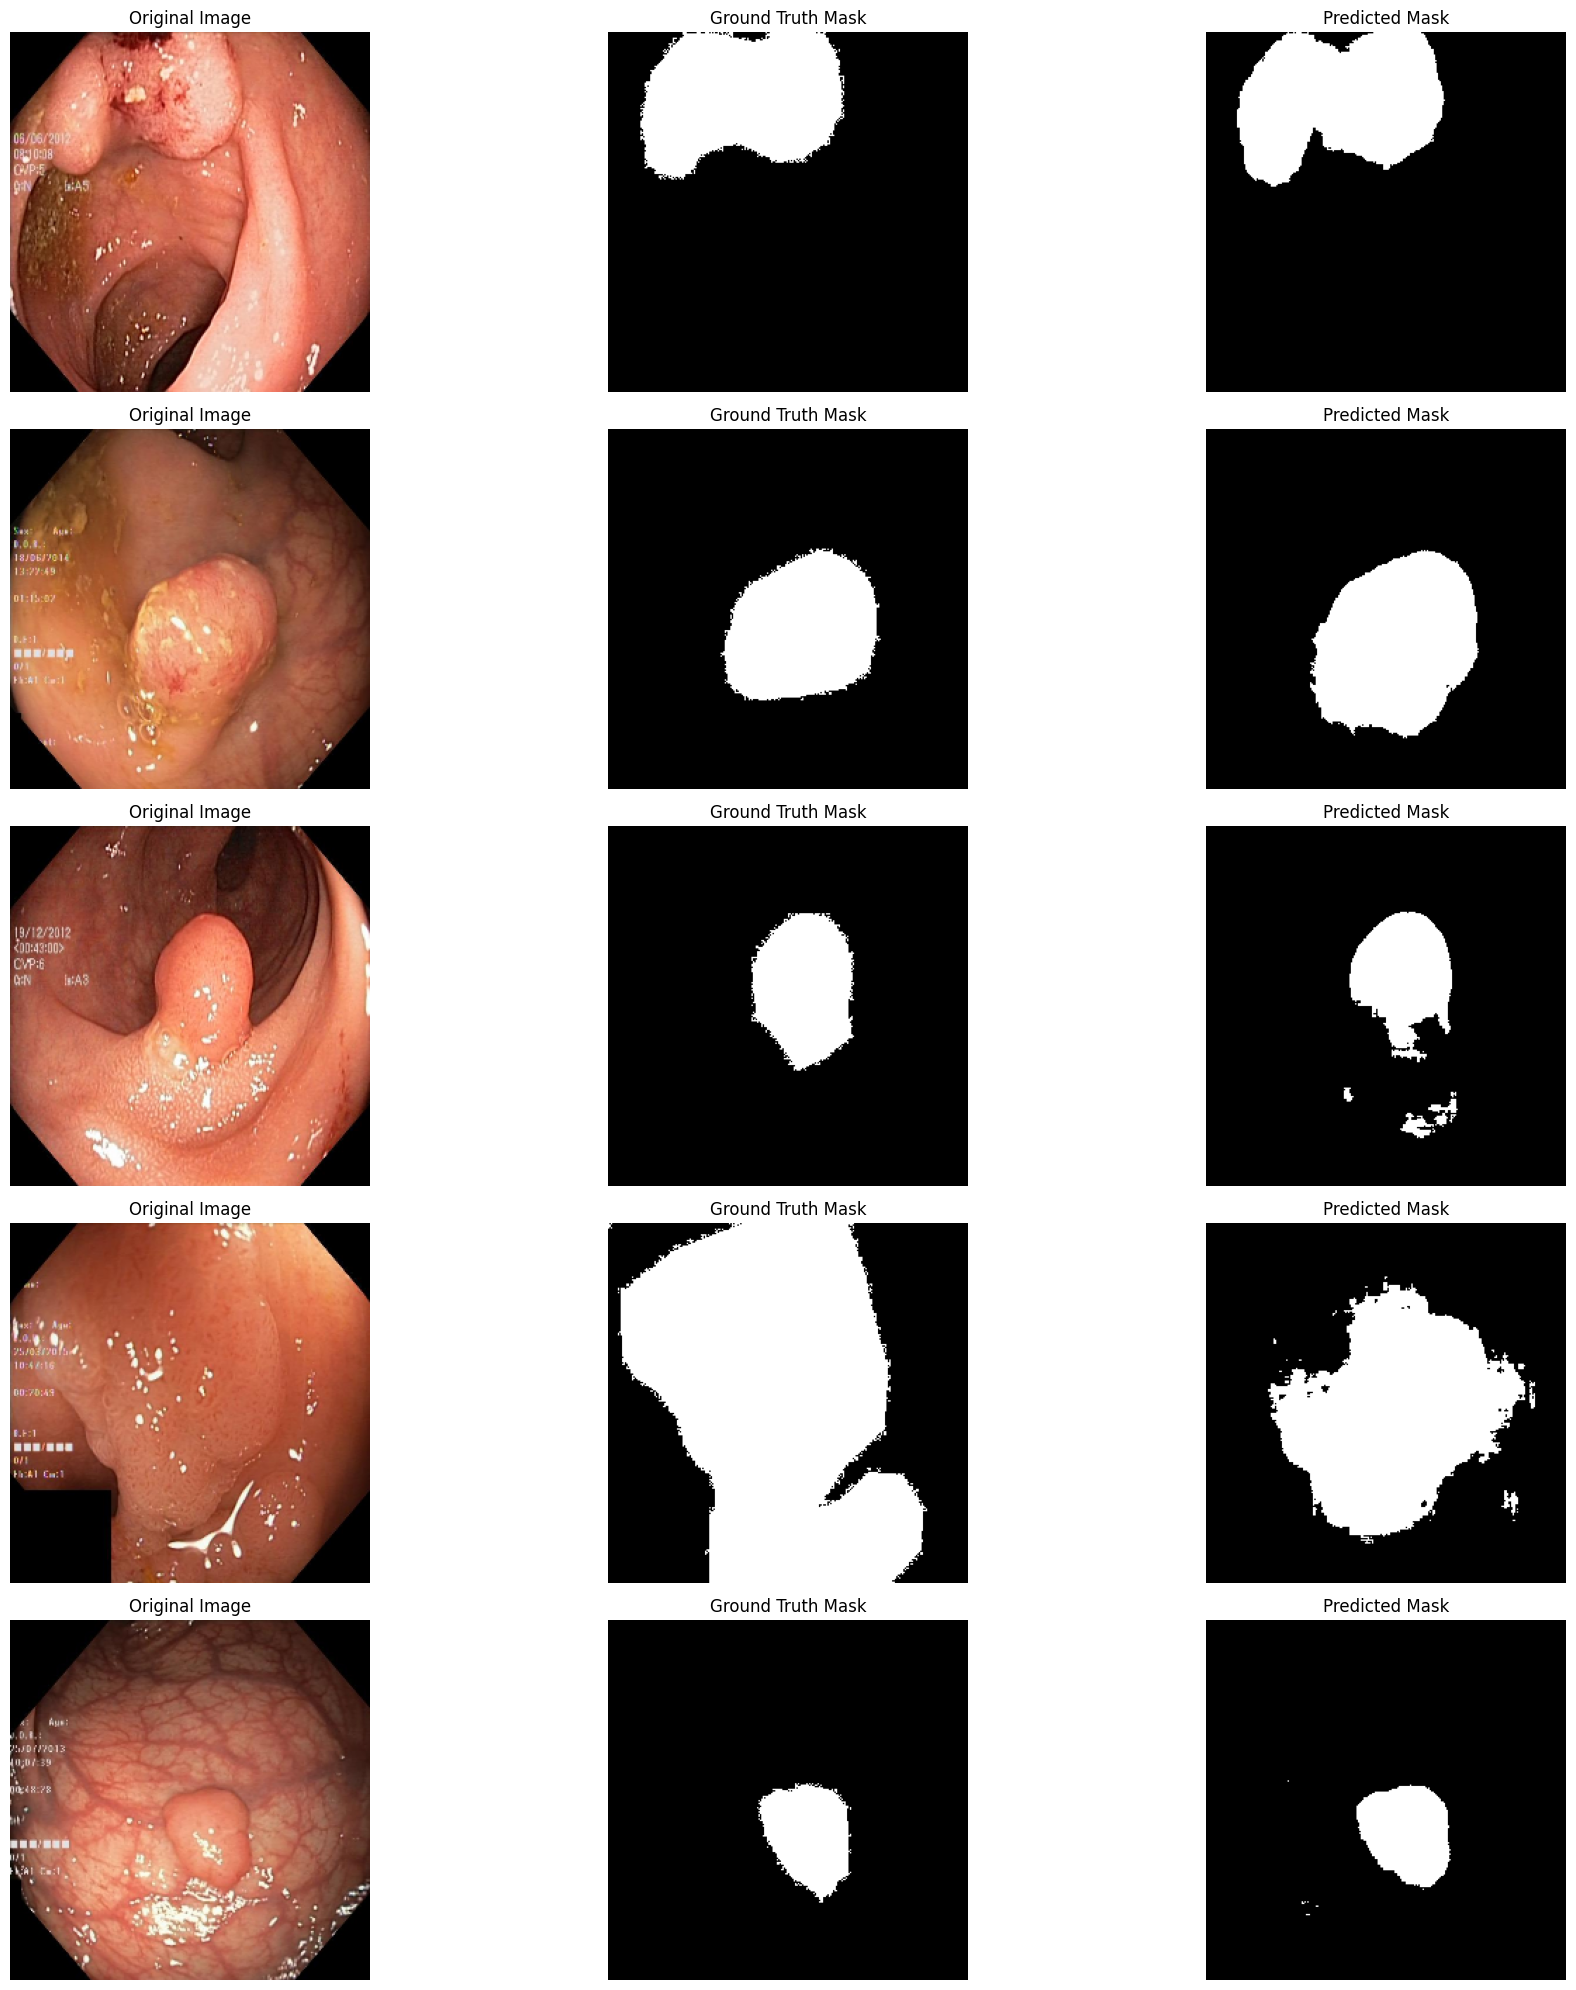

In [10]:
import random

# Predict on test set
test_preds = model.predict(X_test, verbose=1)
test_preds_bin = tf.where(test_preds > 0.5, 1.0, 0.0)

# Number of samples you want to visualize
num_samples = 5
indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(20, num_samples * 4))

for i, idx in enumerate(indices):
    img = X_test[idx]
    true_mask = Y_test[idx]
    pred_mask = test_preds_bin[idx]

    plt.subplot(num_samples, 3, i*3 + 1)
    plt.title("Original Image")
    plt.imshow(img.astype('uint8'))
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 2)
    plt.title("Ground Truth Mask")
    plt.imshow(np.squeeze(true_mask), cmap='gray')
    plt.axis("off")

    plt.subplot(num_samples, 3, i*3 + 3)
    plt.title("Predicted Mask")
    plt.imshow(np.squeeze(pred_mask), cmap='gray')
    plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
def test_from_dataset(index, X_test, Y_test, model):
    import matplotlib.pyplot as plt
    import numpy as np
    import tensorflow as tf

    # Get test image and mask at given index
    img = X_test[index]
    mask = Y_test[index]

    # Preprocess input
    input_img = np.expand_dims(img, axis=0)

    # Predict
    prediction = model.predict(input_img, verbose=0)
    prediction = tf.where(prediction > 0.5, 1.0, 0.0)

    # Plot results
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(img)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(np.squeeze(mask), cmap='gray')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(np.squeeze(prediction), cmap='gray')
    plt.axis("off")

    plt.show()


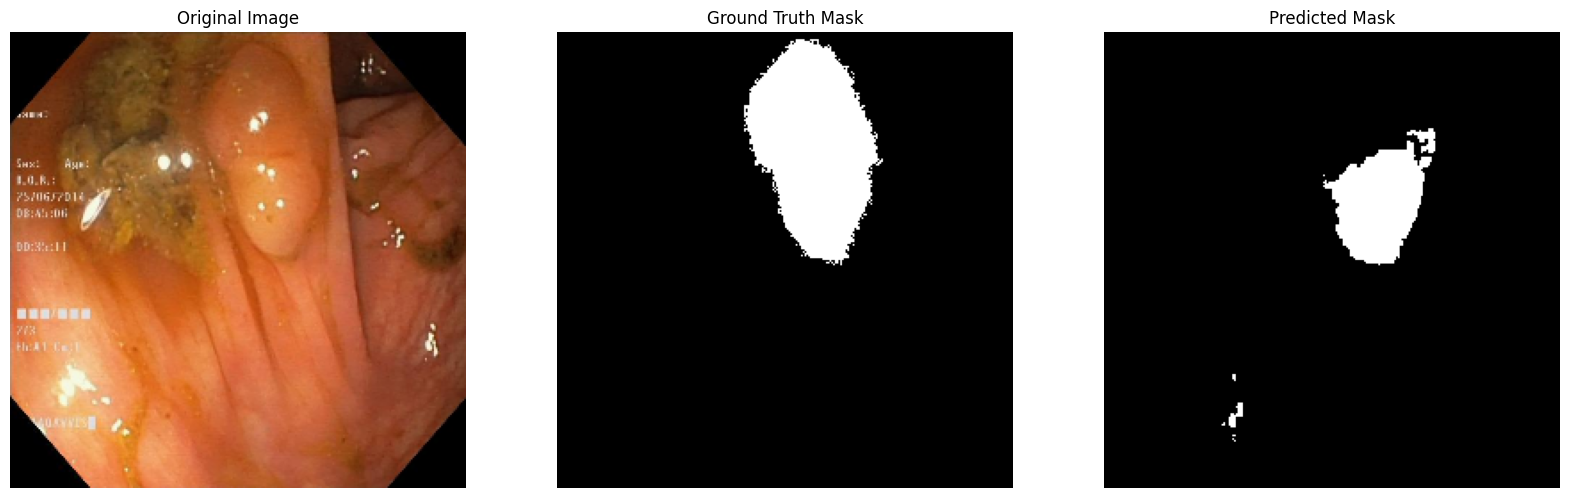

In [12]:
test_from_dataset(0, X_test, Y_test, model)
